In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data

Using TensorFlow backend.


In [2]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import itertools
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error as MSE
    from statsmodels.tsa.seasonal import seasonal_decompose
    

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

# SARIMA

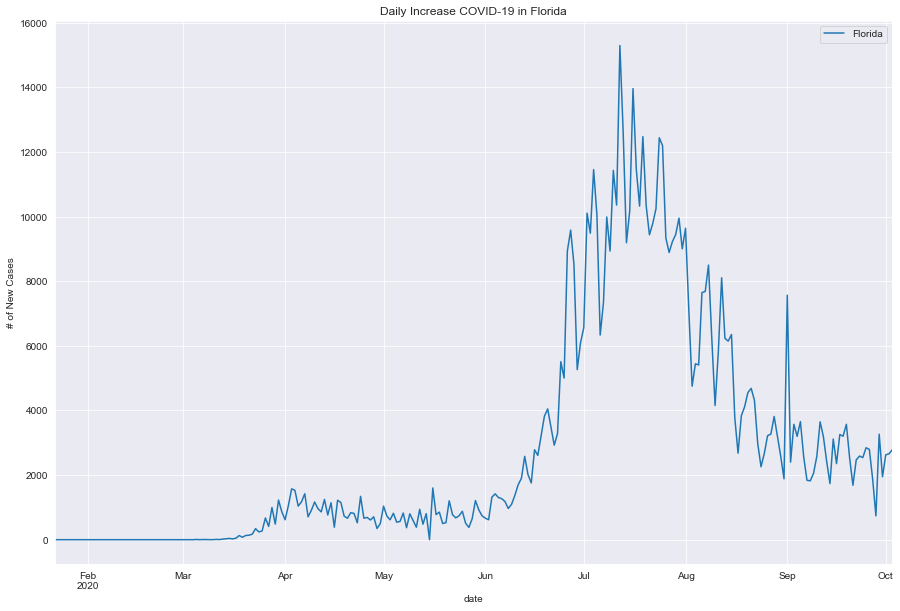

In [3]:
df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# Florida
fl = df['FL_positiveIncrease']
fl.plot(figsize=(15, 10), label='Florida')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in Florida')
plt.legend()
plt.show();


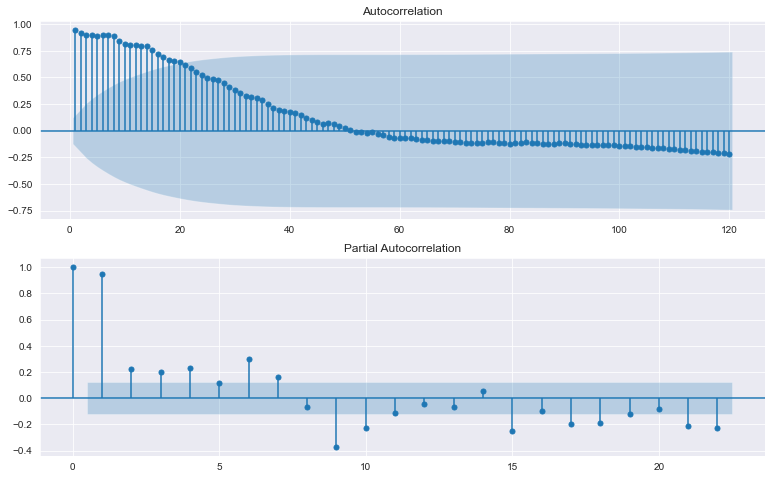

In [4]:
acf_pacf(fl)

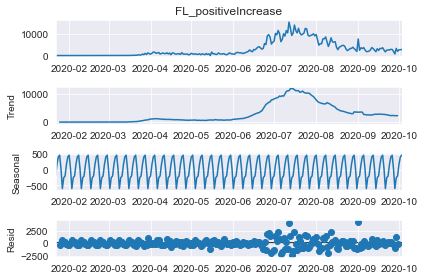

In [5]:
decompose_time_series(fl)

In [6]:
import pmdarima as pm

fl_results = pm.auto_arima(fl,information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=6, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
fl_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4281.882, BIC=4303.130, Fit time=0.536 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4314.190, BIC=4321.272, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4280.730, BIC=4294.895, Fit time=0.114 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4268.715, BIC=4282.880, Fit time=0.284 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4239.586, BIC=4257.293, Fit time=0.643 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=4254.120, BIC=4268.285, Fit time=0.337 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=4239.624, BIC=4260.871, Fit time=1.198 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4287.246, BIC=4297.870, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=4238.134, BIC=4262.923, Fit time=1.110 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 1, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [7]:
fl_train, fl_test = train_test(fl)

                                     SARIMAX Results                                      
Dep. Variable:                FL_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(2, 1, 4)x(2, 0, [], 7)   Log Likelihood               -1674.225
Date:                            Tue, 13 Oct 2020   AIC                           3366.450
Time:                                    14:59:36   BIC                           3396.313
Sample:                                01-22-2020   HQIC                          3378.530
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0458      0.061     -0.755      0.450      -0.165       0.073
ar.L2          0.8134      0.054   

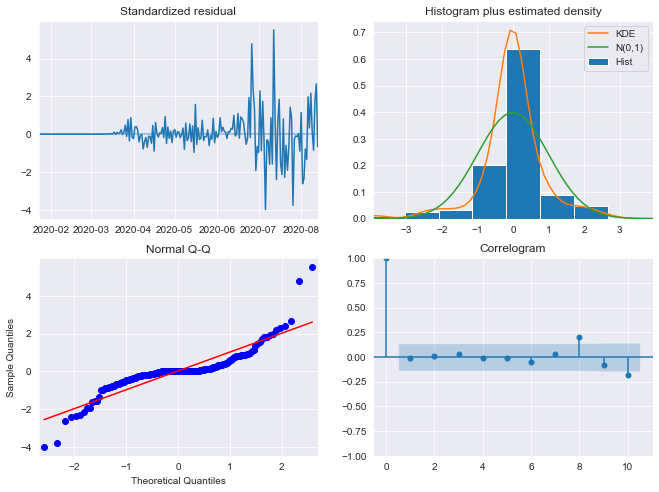

In [8]:
pdq = (2, 1, 4)
pdqs = (2, 0, 0, 7)
train, test, results = fit_model(fl_train, fl_test, pdq=pdq, pdqs=pdqs)

SARIMA model RMSE on train data: 1598.55841


<Figure size 936x432 with 0 Axes>

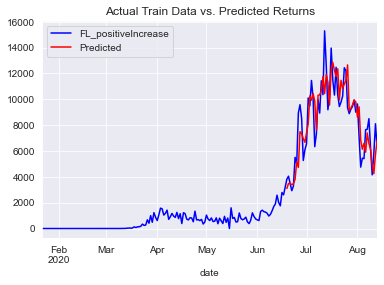

In [9]:
train_RMSE(fl_train, results, display = True)

SARIMA model RMSE on test data: 1082.76225


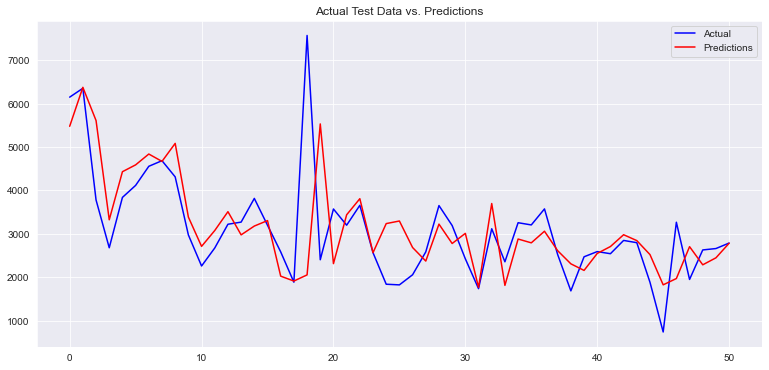

In [10]:
test_RMSE(fl_train, fl_test, pdq, pdqs, display=True)

# LSTM

In [11]:
fl_train, fl_val, fl_test = preprocess_data(fl, 'FL_positiveIncrease')

print(f"Train has {len(fl_train)} values")
print(f"Validation has {len(fl_val)} values")
print(f"Test has {len(fl_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


In [12]:
look_back = 5

X_train, y_train = create_dataset(fl_train, look_back)
X_val, y_val = create_dataset(fl_val, look_back)
X_test, y_test = create_dataset(fl_test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70,
                   validation_data=(X_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                   verbose=1, shuffle=False)

model.summary()

Train on 229 samples, validate on 1 samples
Epoch 1/500
229/229 [==============================] - 1s 2ms/step - loss: 0.0963 - val_loss: 0.0390
Epoch 2/500
229/229 [==============================] - 0s 74us/step - loss: 0.0855 - val_loss: 0.0323
Epoch 3/500
229/229 [==============================] - 0s 65us/step - loss: 0.0749 - val_loss: 0.0262
Epoch 4/500
229/229 [==============================] - 0s 61us/step - loss: 0.0653 - val_loss: 0.0209
Epoch 5/500
229/229 [==============================] - 0s 70us/step - loss: 0.0577 - val_loss: 0.0163
Epoch 6/500
229/229 [==============================] - 0s 70us/step - loss: 0.0499 - val_loss: 0.0123
Epoch 7/500
229/229 [==============================] - 0s 70us/step - loss: 0.0438 - val_loss: 0.0091
Epoch 8/500
229/229 [==============================] - 0s 61us/step - loss: 0.0382 - val_loss: 0.0065
Epoch 9/500
229/229 [==============================] - 0s 61us/step - loss: 0.0317 - val_loss: 0.0044
Epoch 10/500
229/229 [=================

In [14]:
from sklearn.metrics import mean_absolute_error as MAE



In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train[0], train_predict[:,0]))

print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train[0], 
                                                   train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test[0], test_predict[:,0]))

print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test[0], 
                                                  test_predict[:,0])))

Train Mean Absolute Error: 1116.0286870564955
Train Root Mean Squared Error: 1443.7124193632117
Test Mean Absolute Error: 620.283203125
Test Root Mean Squared Error: 922.9525004786495


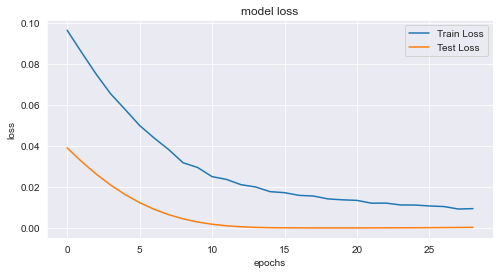

In [16]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

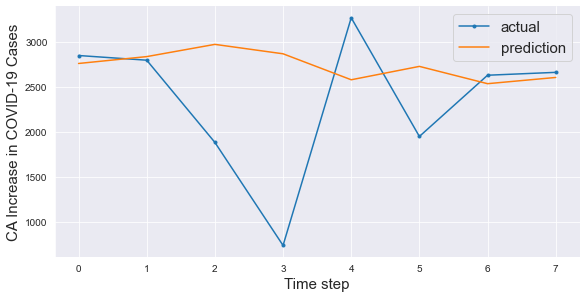

In [17]:
aa=[x for x in range(8)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:8], '-', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('CA Increase in COVID-19 Cases', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();